In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import h5py
import emcee

import sys
sys.path.append('../python/')
sys.path.append('../python/log_likelihood_funcs/')
from EdwRes import *
from prob_dist import *
from edw_data_util import *
from ll_corr1_corrAB import log_likelihood

In [14]:
# if mcmc_test is false then the MCMC sampler will be run
mcmc_test = False

# filename - will save sampler here
import os, subprocess
repo = os.listdir('.')[0]
sha = subprocess.check_output(['git', 'rev-parse', 'HEAD'], cwd=repo).decode('ascii').strip()
filename = 'data/edelweiss_corr1_systematicErrors_sampler_nll_allpars_corrAB_gausPrior_%s.h5' % sha[:7]

# random walks starting near the minimum
ndim, nwalkers = 6, 100
nburn = 500
nsteps = 5000

# initial parameters (usually best-fit point)
aH_fit, C_fit, m_fit, scale_fit = 3.81134613e-02, 3.32613445e-02, 1.11522962e-04, 9.94778557e-01
A_fit, B_fit = 1.53737587e-01, 1.70327657e-01 

In [15]:
ER_data, NR_data = getERNR()

In [16]:
if not mcmc_test:
    pos0 = [[aH_fit, C_fit, m_fit, scale_fit, A_fit, B_fit] + 1e-8*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(ER_data, NR_data))
    pos, prob, state = sampler.run_mcmc(pos0, nburn, storechain=False)
    sampler.reset()
    sampler.run_mcmc(pos, nsteps)
    samples = sampler.chain
    
else:
    f = h5py.File(filename,'r')

    # need to store data in an array:
    # The sampler will now have a chains attribute 
    # which is an array with shape (Nwalker,N,Ndim) 
    # where N is the number of interations (500 in our inital run)
    # and Ndim is the number of fit parameters
    path='{}/{}/'.format('mcmc','sampler')

    aH = np.asarray(f[path+'aH'])
    C = np.asarray(f[path+'C'])
    m = np.asarray(f[path+'m'])
    scale = np.asarray(f[path+'scale'])
    A = np.asarray(f[path+'A'])
    B = np.asarray(f[path+'B'])
    samples = np.asarray(f[path+'samples'])

    f.close()

In [17]:
import os.path

if not mcmc_test:
    #save the MCMC results
    path='{}/{}/'.format('mcmc','sampler')

    #remove vars
    f = h5py.File(filename,'a')
    exaH = path+'aH' in f
    exC = path+'C' in f
    exm = path+'m' in f
    exscale = path+'scale' in f
    exA = path+'A' in f
    exB = path+'B' in f
    exsamp = path+'samples' in f

    if exaH:
      del f[path+'aH']
    if exC:
      del f[path+'C']
    if exm:
      del f[path+'m']
    if exscale:
      del f[path+'scale']
    if exA:
      del f[path+'A']
    if exB:
      del f[path+'B']
    if exsamp:
      del f[path+'samples']

    dset = f.create_dataset(path+'aH',np.shape(aH_fit),dtype=np.dtype('float64').type)
    dset[...] = aH_fit
    dset = f.create_dataset(path+'C',np.shape(C_fit),dtype=np.dtype('float64').type)
    dset[...] = C_fit
    dset = f.create_dataset(path+'m',np.shape(m_fit),dtype=np.dtype('float64').type)
    dset[...] = m_fit
    dset = f.create_dataset(path+'scale',np.shape(scale_fit),dtype=np.dtype('float64').type)
    dset[...] = scale_fit
    dset = f.create_dataset(path+'A',np.shape(A_fit),dtype=np.dtype('float64').type)
    dset[...] = A_fit
    dset = f.create_dataset(path+'B',np.shape(B_fit),dtype=np.dtype('float64').type)
    dset[...] = B_fit
    dset = f.create_dataset(path+'samples',np.shape(samples),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = samples

    f.close()

(100, 5000, 6)
(100, 5000)


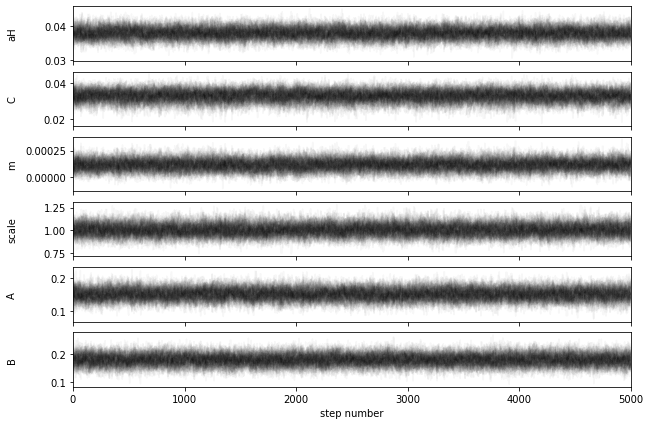

In [18]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

print (np.shape(samples))
print (np.shape(samples[:, :, 1]))
labels = ["aH", "C", "m", "scale", "A", "B"]
for i in range(ndim):
    ax = axes[i]
    # when you pass ax.plot a pair, the columns represent seperate data sets
    ax.plot(np.transpose(samples[:, :, i]), "k", alpha=0.03)
    ax.set_xlim(0, np.shape(samples)[1])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

C:\Users\canto\Anaconda3\envs\nr_fano\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


(100, 5000, 6)
(470000, 6)


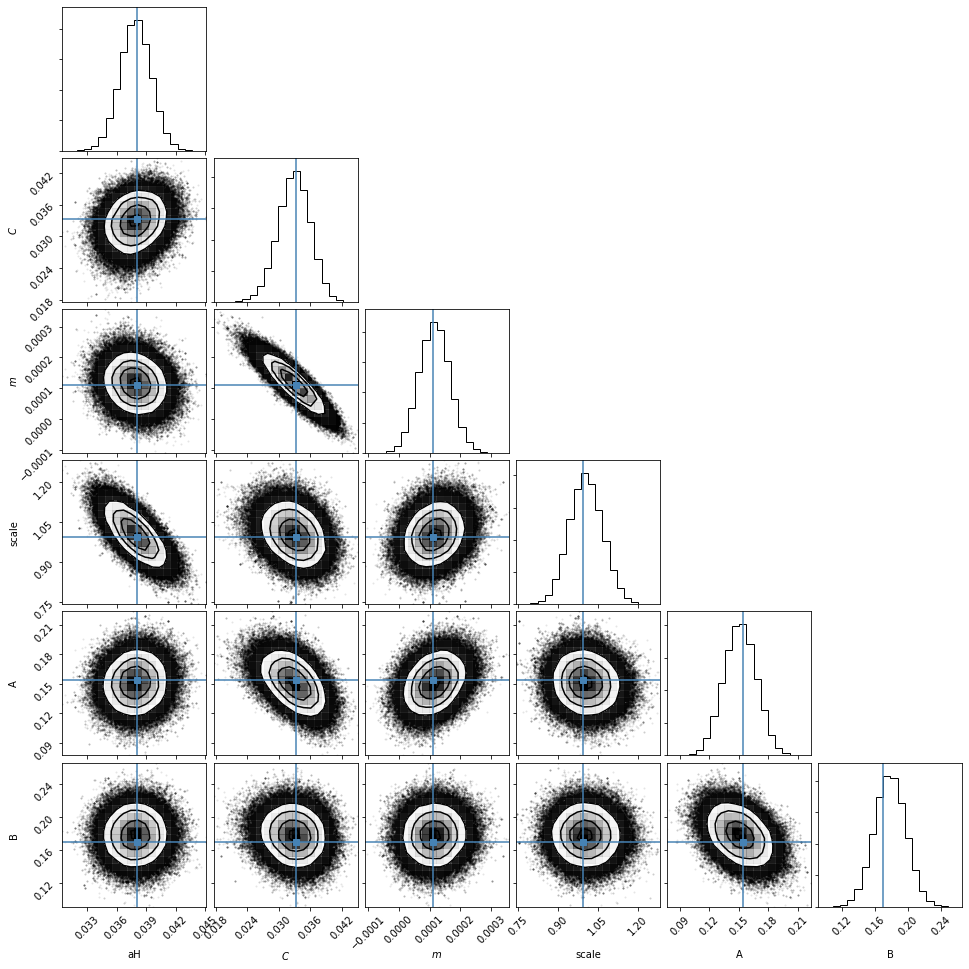

In [19]:
import corner
print(np.shape(samples))
samples_corner = samples[:, 300:, :].reshape((-1, ndim))
print(np.shape(samples_corner))
fig = corner.corner(samples_corner, labels=["aH", "$C$", "$m$", "scale", "A", "B"],
                      truths=[aH_fit, C_fit, m_fit, scale_fit, A_fit, B_fit])

if False:
    plt.savefig('pics/corner_sixParameter_fit_corr.png')